# Sentiment Analysis

Sentiment analysis is the process of using natural language processing and statistical methods to identify and quantify the emotional tone or sentiment expressed in text data, such as customer reviews, social media posts, or survey responses. This technique categorizes sentiment as positive, negative, or neutral, often with additional granularity or contextual insights. Sentiment analysis is valuable to businesses because it helps them gauge customer opinions, monitor brand reputation, and identify emerging trends in customer feedback at scale. With the output of sentiment analysis, businesses can improve customer experience by addressing negative feedback proactively, enhance marketing strategies by understanding customer sentiment toward campaigns or products, and make data-driven decisions to optimize operations or product offerings. For example, a company might use sentiment trends to fine-tune its messaging, prioritize product development based on customer frustrations, or measure the effectiveness of customer support.

Traditional methods of sentiment analysis are primarily supervised methods, that is, they train an ML model with a dataset of input texts that are labeled as positive or negative. The resulting model can then be used to predict whether an input text is positive or negative. However, this isn't the full use of sentiment analysis for a business. Significantly more value is delivered when sentiment analysis is done with the intent to extract actionable insights. It is with this in mind that we'll do this analysis.

We'll explore 2 methods of sentiment prediction:
1. Polarity with VADER
2. Contextual Polarity with Bert

Then we'll explore 2 methods of extracting themes and insights:
1.

## Importing Libraries and Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np # pip install "numpy<2.0"; bert was compiled with Numpy1
import pandas as pd
from tqdm import tqdm
import nltk

Our dataset is a collection of JSONLs from Yelp. The dataset can be found [here](https://www.yelp.com/dataset). The full data download has a few JSON files in it, but we're only concerned with the 'reviews' file. This file is composed of JSON lines, where each line is a review. There are almost 7 million reviews for various businesses, so our first step should be to focus on one business--the business with the highest review count.

Additionally, loading this file is going to take a huge chunk of memory. Because of how Python consumes and doesn't release memory, I'm going to filter the dataset, save the filtered dataset as a new file, then restart the Python kernel and start fresh with the smaller dataset. The following code was run only once, which is why the next 5 cells have "%%script echo skipping" at the top. This tag effectively skips executing the contents of the cell and proceeds onward.

In [2]:
%%script echo skipping 1
df = pd.read_json("yelp_academic_dataset_review.json", lines=True) # Dataset is huge, so this takes awhile to load
print(f"Number of Reviews: {df.shape[0]}\n") # 6,990,280
df.dtypes

skipping 1


In [3]:
%%script echo skipping 2
# Group our dataset by business_id and count the number of reviews for each business
grouped_df = df.groupby("business_id").size().reset_index(name='review_count')
print(f"Number of Businesses: {grouped_df.shape[0]}") # 150,346
grouped_df = grouped_df.sort_values(by='review_count', ascending=False)
grouped_df.head()

skipping 2


In [4]:
%%script echo skipping 3
# Create a new df with just our target business
target_business_id = "_ab50qdWOk0DdB6XOrBitw"
filtered_df = df[df['business_id'] == target_business_id]
print(f"Number of Reviews: {filtered_df.shape[0]}\n") # 7,673

skipping 3


This still results in 7600+ reviews, which is a lot of data to sift through. Let's limit our sample to 3500 reviews:

In [5]:
%%script echo skipping 4
filtered_df = filtered_df.sample(3500, random_state=42) # using random_state for reproducability
filtered_df = filtered_df.drop(columns="business_id") # not needed since we're only using one business_id
print(f"Number of Reviews: {filtered_df.shape[0]}\n") # 3,500
filtered_df.head()

skipping 4


In [6]:
%%script echo skipping 5
filtered_df.to_json("filtered_reviews.json", orient="records", lines=True)

skipping 5


## EDA

Now that we have our dataset filtered and saved, we'll restart the kernel and load the smaller dataset:

In [7]:
df = pd.read_json("filtered_reviews.json", lines=True)
df.head()

,review_id,user_id,stars,useful,funny,cool,text,date
0,RtBfA39-KIcIpq5N46fXSg,ChrdTlE-ATD7kil4mPU14w,2,0,0,0,After coming here many times to enjoy the gril...,2019-11-11 12:10:48
1,iVnpCJfCMJWWEWPYqnPEOg,7xvYZiNeeLQ_p1fswEguQg,5,0,0,0,Food was great. We tried a variety of differe...,2017-08-13 00:19:12
2,4VzTeOhkxeZlZmBRCBP4lg,7iNg1KUbf8AaZItq1pr0Qw,4,0,0,0,This place has a HUGE wait so get there early....,2013-11-13 18:21:53
3,QC9p4nlAEJuxe5TuDfr47w,D2WBLgdkgS69phazNyk8fA,5,0,0,0,Definitely a great lunch in New Orleans! We go...,2013-10-23 18:36:12
4,1R6megnEDDHDeCWIZrmmaw,IfZ1vqGIX31AmDFa0swSRw,4,0,0,0,I swung by on my walk from the Market in the F...,2011-08-30 21:05:42


Let's do some quick EDA to see what the distribution of our data looks like.

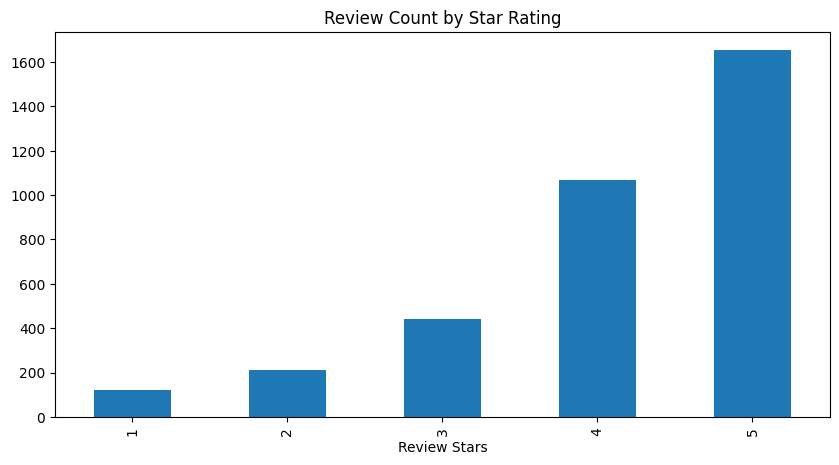

In [8]:
# Plot the review count by star rating
fig = df['stars'].value_counts().sort_index().plot(kind='bar',
                                                            title='Review Count by Star Rating',
                                                            figsize=(10, 5))
fig.set_xlabel('Review Stars')
plt.show()

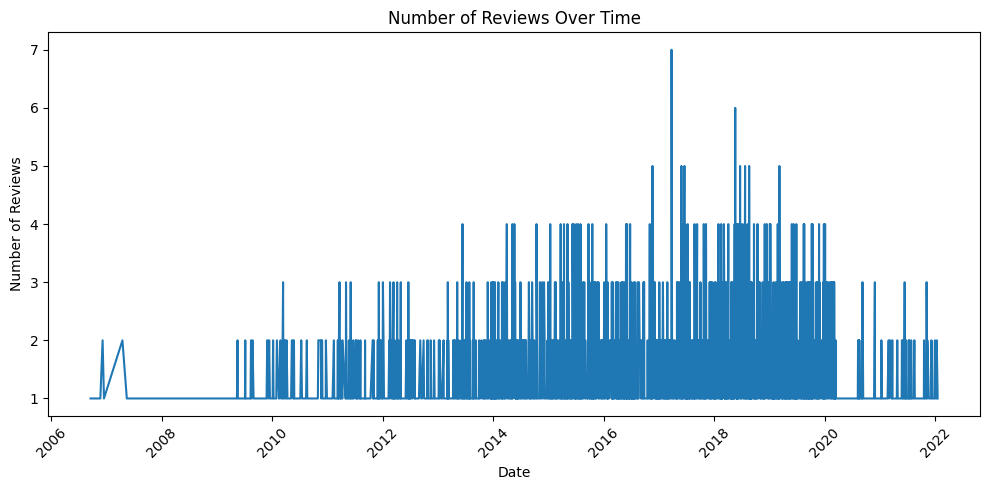

In [9]:
# Plot count of reviews by date
date_counts = df.groupby(df['date'].dt.date).size()

plt.figure(figsize=(10, 5))
plt.plot(date_counts.index, date_counts.values)
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

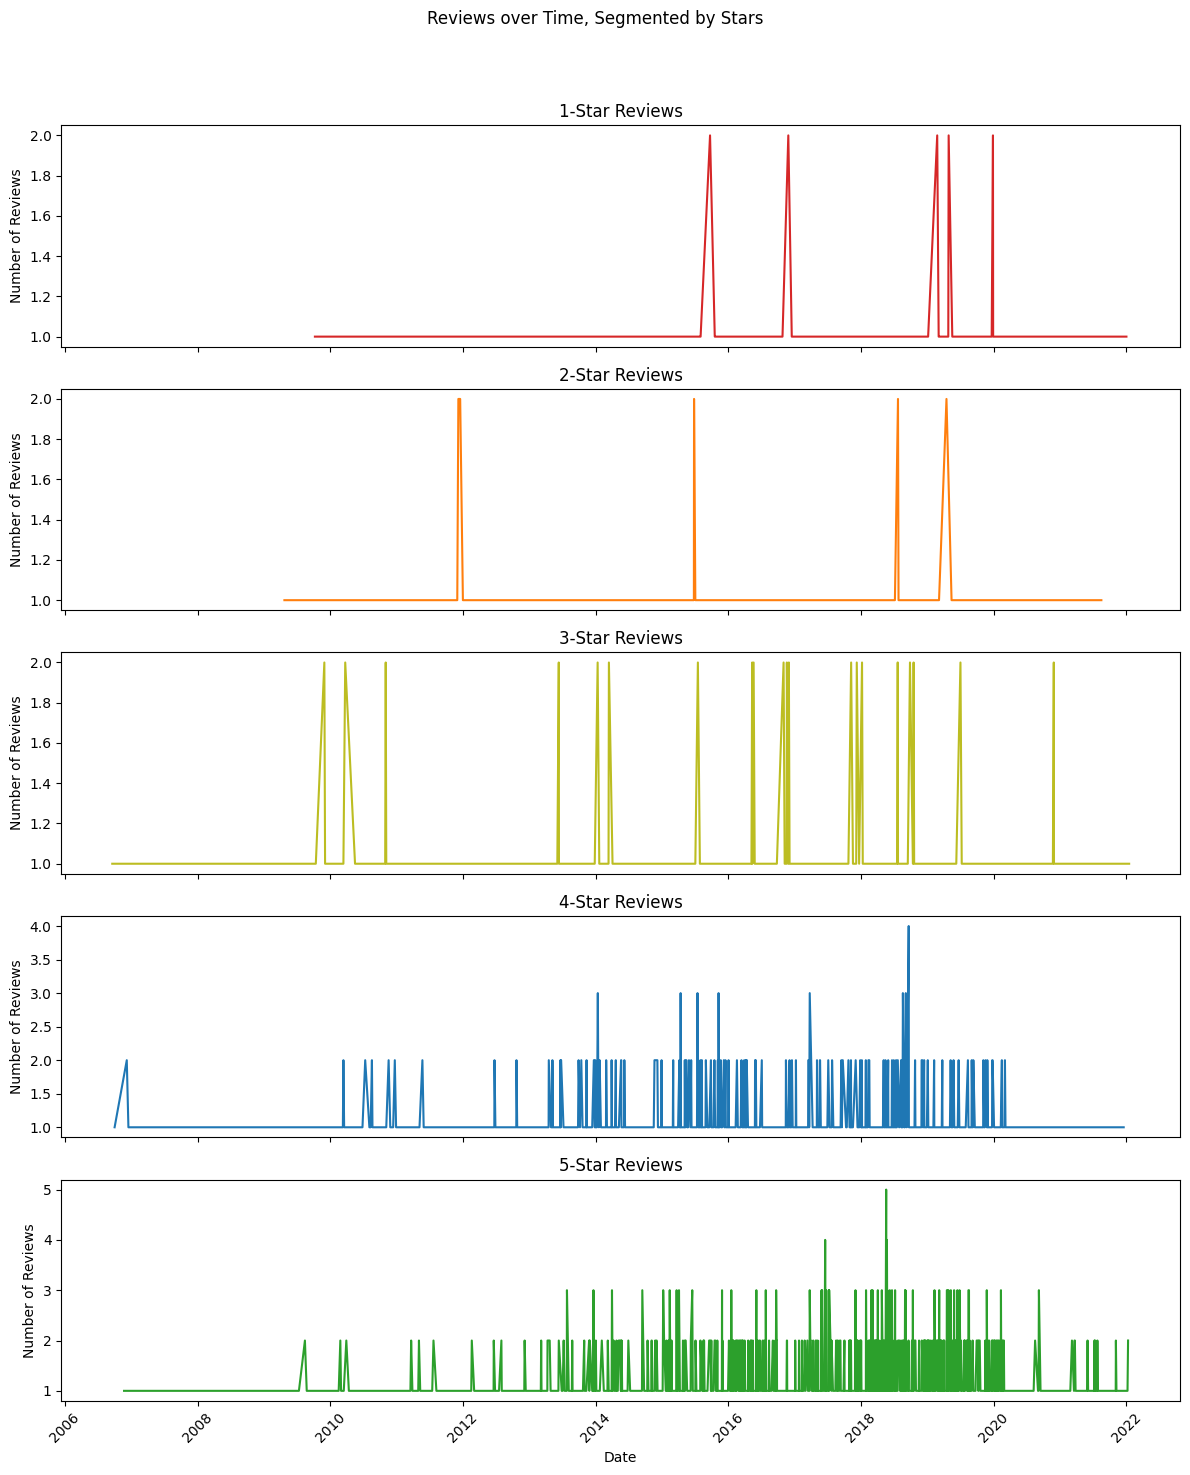

In [10]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, sharex=True, figsize=(12, 15))
fig.suptitle('Reviews over Time, Segmented by Stars')
star_ratings = [1, 2, 3, 4, 5]
colors = ['red', 'orange', 'olive', 'blue', 'green']
axes = [ax1, ax2, ax3, ax4, ax5]

for stars, ax, color in zip(star_ratings, axes, colors):
    star_df = df[df['stars'] == stars]
    date_counts = star_df.groupby(star_df['date'].dt.date).size()

    ax.plot(date_counts.index, date_counts.values, 'tab:'+color)
    ax.set_title(f'{stars}-Star Reviews')
    ax.set_ylabel('Number of Reviews')

# Set common labels
ax5.set_xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust spacing to avoid title overlap
plt.show()

## Preprocessing

In [11]:
df = df.drop(columns=['user_id', 'useful', 'funny', 'cool']) # drop unnecessary cols
df.head()

,review_id,stars,text,date
0,RtBfA39-KIcIpq5N46fXSg,2,After coming here many times to enjoy the gril...,2019-11-11 12:10:48
1,iVnpCJfCMJWWEWPYqnPEOg,5,Food was great. We tried a variety of differe...,2017-08-13 00:19:12
2,4VzTeOhkxeZlZmBRCBP4lg,4,This place has a HUGE wait so get there early....,2013-11-13 18:21:53
3,QC9p4nlAEJuxe5TuDfr47w,5,Definitely a great lunch in New Orleans! We go...,2013-10-23 18:36:12
4,1R6megnEDDHDeCWIZrmmaw,4,I swung by on my walk from the Market in the F...,2011-08-30 21:05:42


## VADER Sentiment Scoring Analysis

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a pre-trained heuristic-based tool that returns a sentiment score for an input text. VADER uses a dictionary of words and rules to determine a positive, neutral, and negative polarity score for each word. The scores for each word are aggregated to reach an compound score. The polarity score ranges from -4 to +4, with -4 being the most negative and +4 being the most positive. Vader also takes into account the intensity of the sentiment, which can be influenced by capitalization and punctuation. If a review is in all caps, that review will be understood to be more intense (whether positive or negative).

Normally, we would need to preprocess our text data: convert to lowercase, remove stopwords, stemming, etc. In traditional sentiment analysis methods, input text needs to be extensively reduced to increase the density of information. But with newer approaches like LLMs and BERT, this preprocessing isn't needed. Transformer-based models use the entirety of a text input, including all stopwords. These stopwords, while not sentiment-dense, do change the semantic meaning of the text. Transformers can pick up on that semantic meaning, while rule-based models cannot.

In [12]:
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()
example_pos_text = "I'm so excited right now!"
example_neg_text = "I'm so scared right now..."
print(f"Example Positive Scores: {sia.polarity_scores(example_pos_text)}")
print(f"Example Negative Scores: {sia.polarity_scores(example_neg_text)}")

Example Positive Scores: {'neg': 0.0, 'neu': 0.573, 'pos': 0.427, 'compound': 0.4561}
Example Negative Scores: {'neg': 0.444, 'neu': 0.556, 'pos': 0.0, 'compound': -0.4927}


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


With this demo, we can get polarity scores for our dataset:

In [13]:
results = {}
for i, row in df.iterrows():
    text = row['text']
    review_id = row['review_id']
    results[review_id] = sia.polarity_scores(text)

In [14]:
# Merge the polarity results with our existing df
vader_scores = pd.DataFrame(results).T
vader_scores = vader_scores.reset_index().rename(columns={'index': 'review_id'})
vader_scores.rename(columns={
    'neg': 'vader_negative',
    'neu': 'vader_neutral',
    'pos': 'vader_positive'
}, inplace=True)
df = df.merge(vader_scores, how='left')
df.head()

,review_id,stars,text,date,vader_negative,vader_neutral,vader_positive,compound
0,RtBfA39-KIcIpq5N46fXSg,2,After coming here many times to enjoy the gril...,2019-11-11 12:10:48,0.111,0.751,0.138,0.4387
1,iVnpCJfCMJWWEWPYqnPEOg,5,Food was great. We tried a variety of differe...,2017-08-13 00:19:12,0.040,0.650,0.310,0.9428
2,4VzTeOhkxeZlZmBRCBP4lg,4,This place has a HUGE wait so get there early....,2013-11-13 18:21:53,0.169,0.611,0.220,0.5978
3,QC9p4nlAEJuxe5TuDfr47w,5,Definitely a great lunch in New Orleans! We go...,2013-10-23 18:36:12,0.029,0.654,0.316,0.9946
4,1R6megnEDDHDeCWIZrmmaw,4,I swung by on my walk from the Market in the F...,2011-08-30 21:05:42,0.089,0.809,0.102,0.5800


Let's visualize these scores, both in general and segmented by negative/neutral/positive scores:

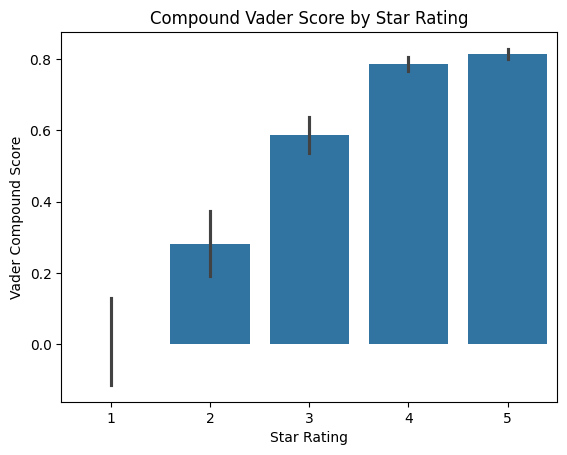

In [15]:
# Plot the VADER data
import seaborn as sns
ax = sns.barplot(data=df, x='stars', y='compound')
ax.set_ylabel('Vader Compound Score')
ax.set_xlabel('Star Rating')
ax.set_title('Compound Vader Score by Star Rating')
plt.show()

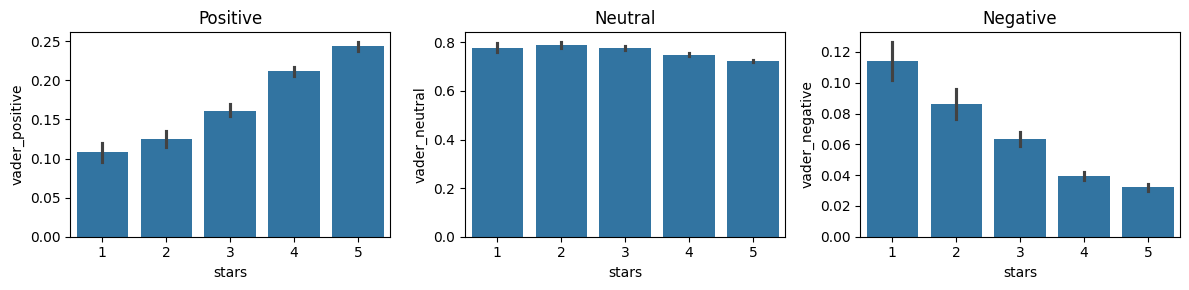

In [16]:
# Plot segmented review scores
fig, (ax_pos, ax_neu, ax_neg) = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=df, x='stars', y='vader_positive', ax=ax_pos)
sns.barplot(data=df, x='stars', y='vader_neutral', ax=ax_neu)
sns.barplot(data=df, x='stars', y='vader_negative', ax=ax_neg)
ax_pos.set_title('Positive')
ax_neu.set_title('Neutral')
ax_neg.set_title('Negative')
plt.tight_layout()
plt.show()

While VADER is a quick and easy way to extract sentiment polarity, it struggles with higher-order aspects of human language:
1. Context: Vader uses a predefined lexicon with manually assigned sentiment scores. This makes it brittle and context-unaware.
2. Polysemy: Polysemy is the attribute of having multiple meanings. For example, the word 'good' in "Good riddance!" is semantically different from bank in "That's very good!". Because Vader uses static word sentiment scores, it cannot adjust for polysemy.
3. Sarcasm and Idiomatic Language: Vader's rule based approach limits its ability to correctly interpret sarcasm. Vader would likely predict "I LOVE how terrible this service is" as being positive.
4. Generalization: While powerful, Vader was only trained on casual text from social media. This training data scope limits Vader's ability to generalize to unseen data.

Enter BERT:

## BERT Sentiment Scoring

BERT (Bidirectional Encoder Representations from Transformers) is a bedrock transformer-based language model. Bert uses deep neural networks with multiple heads of attention to understand the meaning of words by analyzing the preceding and proceeding context of a word simultaneously, making it bidirectional. Pre-trained on massive datasets like Wikipedia and BookCorpus, bert can be tuned for various NLP tasks including sentiment analysis, question answering, and language translation. Although Bert is relatively old and was recently succeeded by ModernBert, it's still considered a foundational model for text tasks.

Bert improves on everything that Vader struggles with:
1. Context: Bert is trained and fine tuned on massive datasets that enable it to understand the context and semantics of words in a sentence. Bert processes words in relation to each other, enabling it to detect higher orders of sentiment and meaning.
2. Polysemy: Because Bert assigns meaning based on context, it can correctly interpret words with different meanings.
3. Idiomatic Language: Because Bert's training corpus included data with sarcasm and idioms, it can understand those same idioms of speech.
4. Generalization: Bert is trained and tuned on open-domain text data, greatly improving its ability to generalize to unseen text.

Bert has spawned a HUGE range of tuned versions. The version we'll use here is a newer sentiment analysis tuning. We'll run this model from HuggingFace.

In [17]:
# Import Sentiment-tuned Bert Model
import torch
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model_id = "clapAI/modernBERT-base-multilingual-sentiment"
model_id = "cardiffnlp/twitter-roberta-base-sentiment-latest"
# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_id)
config = AutoConfig.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(model_id, torch_dtype=torch.float32)

model.to(device)
model.eval()
pos_input = tokenizer(example_pos_text, return_tensors="pt").to(device)
neg_input = tokenizer(example_neg_text, return_tensors="pt").to(device)

# Perform inference in inference mode
with torch.inference_mode():
    pos_outputs = model(**pos_input) # type SequenceClassifierOutput
    pos_scores = pos_outputs[0][0].cpu().detach().numpy() # detach pulls out logits tensor, numpy converts to ndarray of 3 floats
    pos_scores = softmax(pos_scores) # list of 3 normalized floats

    neg_outputs = model(**neg_input)
    neg_scores = neg_outputs[0][0].cpu().detach().numpy()
    neg_scores = softmax(neg_scores)

pos_human_scores = {}
neg_human_scores = {}

# Format pos scores
for i, label in enumerate(config.id2label.values()):
    pos_human_scores[str(label)] = round(float(pos_scores[i]), 4)
# Format neg scores
for i, label in enumerate(config.id2label.values()):
    neg_human_scores[str(label)] = round(float(neg_scores[i]), 4)

print(f"\nPositive Example Vader Scores: {sia.polarity_scores(example_pos_text)}")
print(f"Positive Example Bert Scores: {pos_human_scores}\n")
print(f"Negative Example Vader Scores: {sia.polarity_scores(example_neg_text)}")
print(f"Negative Example Bert Scores: {neg_human_scores}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT e


Positive Example Vader Scores: {'neg': 0.0, 'neu': 0.573, 'pos': 0.427, 'compound': 0.4561}
Positive Example Bert Scores: {'negative': 0.0042, 'neutral': 0.0083, 'positive': 0.9876}

Negative Example Vader Scores: {'neg': 0.444, 'neu': 0.556, 'pos': 0.0, 'compound': -0.4927}
Negative Example Bert Scores: {'negative': 0.8798, 'neutral': 0.1078, 'positive': 0.0124}


As we can see, our model produces a similar output format to Vader. With that demo in mind, let's run Bert against our dataset. This will take a few mins to run:

In [18]:
bert_results = {}

# convert columns to lists for faster iteration
texts = df['text'].tolist()
review_ids = df['review_id'].tolist()
tokenized_texts = []

for text in tqdm(texts, total = len(texts), desc="Tokenizing"):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device) # send to device
    tokenized_texts.append(tokens)

for token_text, review_idx in tqdm(zip(tokenized_texts, review_ids), total=len(tokenized_texts), desc="Predicting"):
    try:
        with torch.inference_mode():
            bert_output = model(**token_text) # send input through bert
            scores = bert_output[0][0].cpu().detach().numpy() # send response to cpu, extract logitsfrom response, convert to ndarray
            scores = softmax(scores) # normalize scores

        current_review_scores = {}
        for i, label in enumerate(config.id2label.values()): # for each label (negative, neutral, positive)
            current_review_scores[str(label)] = round(float(scores[i]), 4) # add {label:score} to the current review score dict

        bert_results[review_idx] = current_review_scores # add {review_idx:scores} to overall dict'
    except Exception as e:
         print(f"Broke for review_id: {review_idx}")
         print(f"Error trace: {e}")

Predicting: 100%|██████████| 3500/3500 [00:40<00:00, 85.37it/s]


In [19]:
bert_df = pd.DataFrame.from_dict(bert_results, orient='index').reset_index()
bert_df.rename(columns={
    'index': 'review_id',
    'negative': 'bert_negative',
    'neutral': 'bert_neutral',
    'positive': 'bert_positive'
}, inplace=True)
df = df.merge(bert_df, on='review_id', how='left')
df.head()


,review_id,stars,text,date,vader_negative,vader_neutral,vader_positive,compound,bert_negative,bert_neutral,bert_positive
0,RtBfA39-KIcIpq5N46fXSg,2,After coming here many times to enjoy the gril...,2019-11-11 12:10:48,0.111,0.751,0.138,0.4387,0.8521,0.1172,0.0307
1,iVnpCJfCMJWWEWPYqnPEOg,5,Food was great. We tried a variety of differe...,2017-08-13 00:19:12,0.040,0.650,0.310,0.9428,0.0034,0.0117,0.9849
2,4VzTeOhkxeZlZmBRCBP4lg,4,This place has a HUGE wait so get there early....,2013-11-13 18:21:53,0.169,0.611,0.220,0.5978,0.1969,0.2144,0.5887
3,QC9p4nlAEJuxe5TuDfr47w,5,Definitely a great lunch in New Orleans! We go...,2013-10-23 18:36:12,0.029,0.654,0.316,0.9946,0.0032,0.0169,0.9798
4,1R6megnEDDHDeCWIZrmmaw,4,I swung by on my walk from the Market in the F...,2011-08-30 21:05:42,0.089,0.809,0.102,0.5800,0.0119,0.1514,0.8367


Now let's visualize!

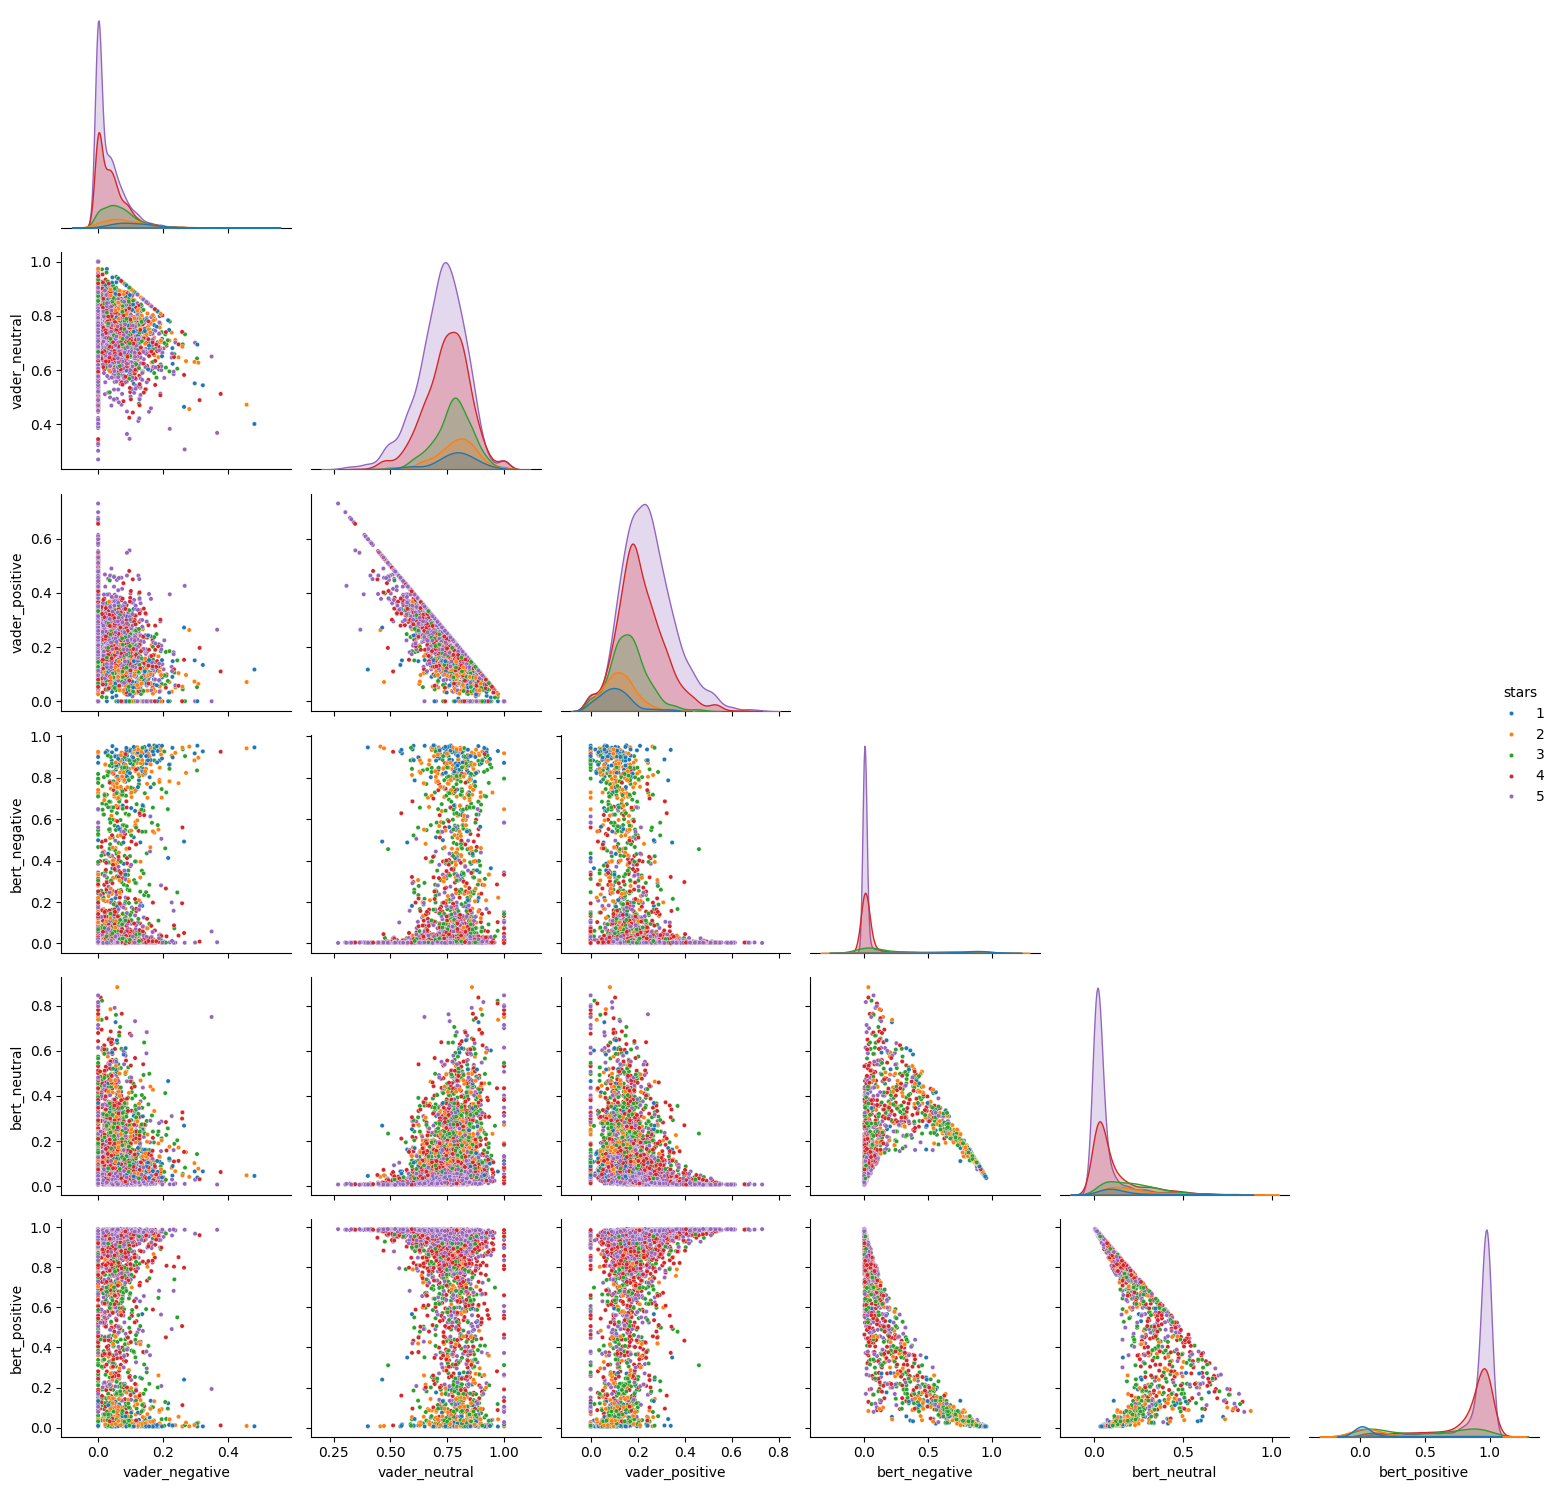

In [20]:
sns.pairplot(data=df,
             vars=['vader_negative', 'vader_neutral', 'vader_positive',
                  'bert_negative', 'bert_neutral', 'bert_positive'],
            hue='stars',
            palette='tab10',
            corner=True,
            plot_kws={"s": 10})
plt.tight_layout()
plt.show()

The top-L:bottom-R diagonol plots show the distribution of each rating (neg, pos, bert_negative, etc).
- Vader scores appear more evenly distributed, while Bert scores appear to be more polarized (note the tight peaks for bert_negative and bert_positive).
- As expected, higher star ratings are generally correlated with more positive sentiment scores.
- We can also see that neutral scores are more evenly distributed across all star ratings, especially for Vader scores.
- Comparing like-sentiment scores (IE vader_positive:bert_positive, vader_negative:bert_negative), we can see some correlation but also some differences in how each model scores reviews. Bert seems to generate more confident (extreme) scores compared to Vader, which produces clusters more in the middle range.
- Vader seems to favor neutral scores, which could indicate that Bert captures subtle positive/negative sentiments that Vader cannot.

Let's calculate the actual correlation values for each variable pairing, to examine where and how each model differs:

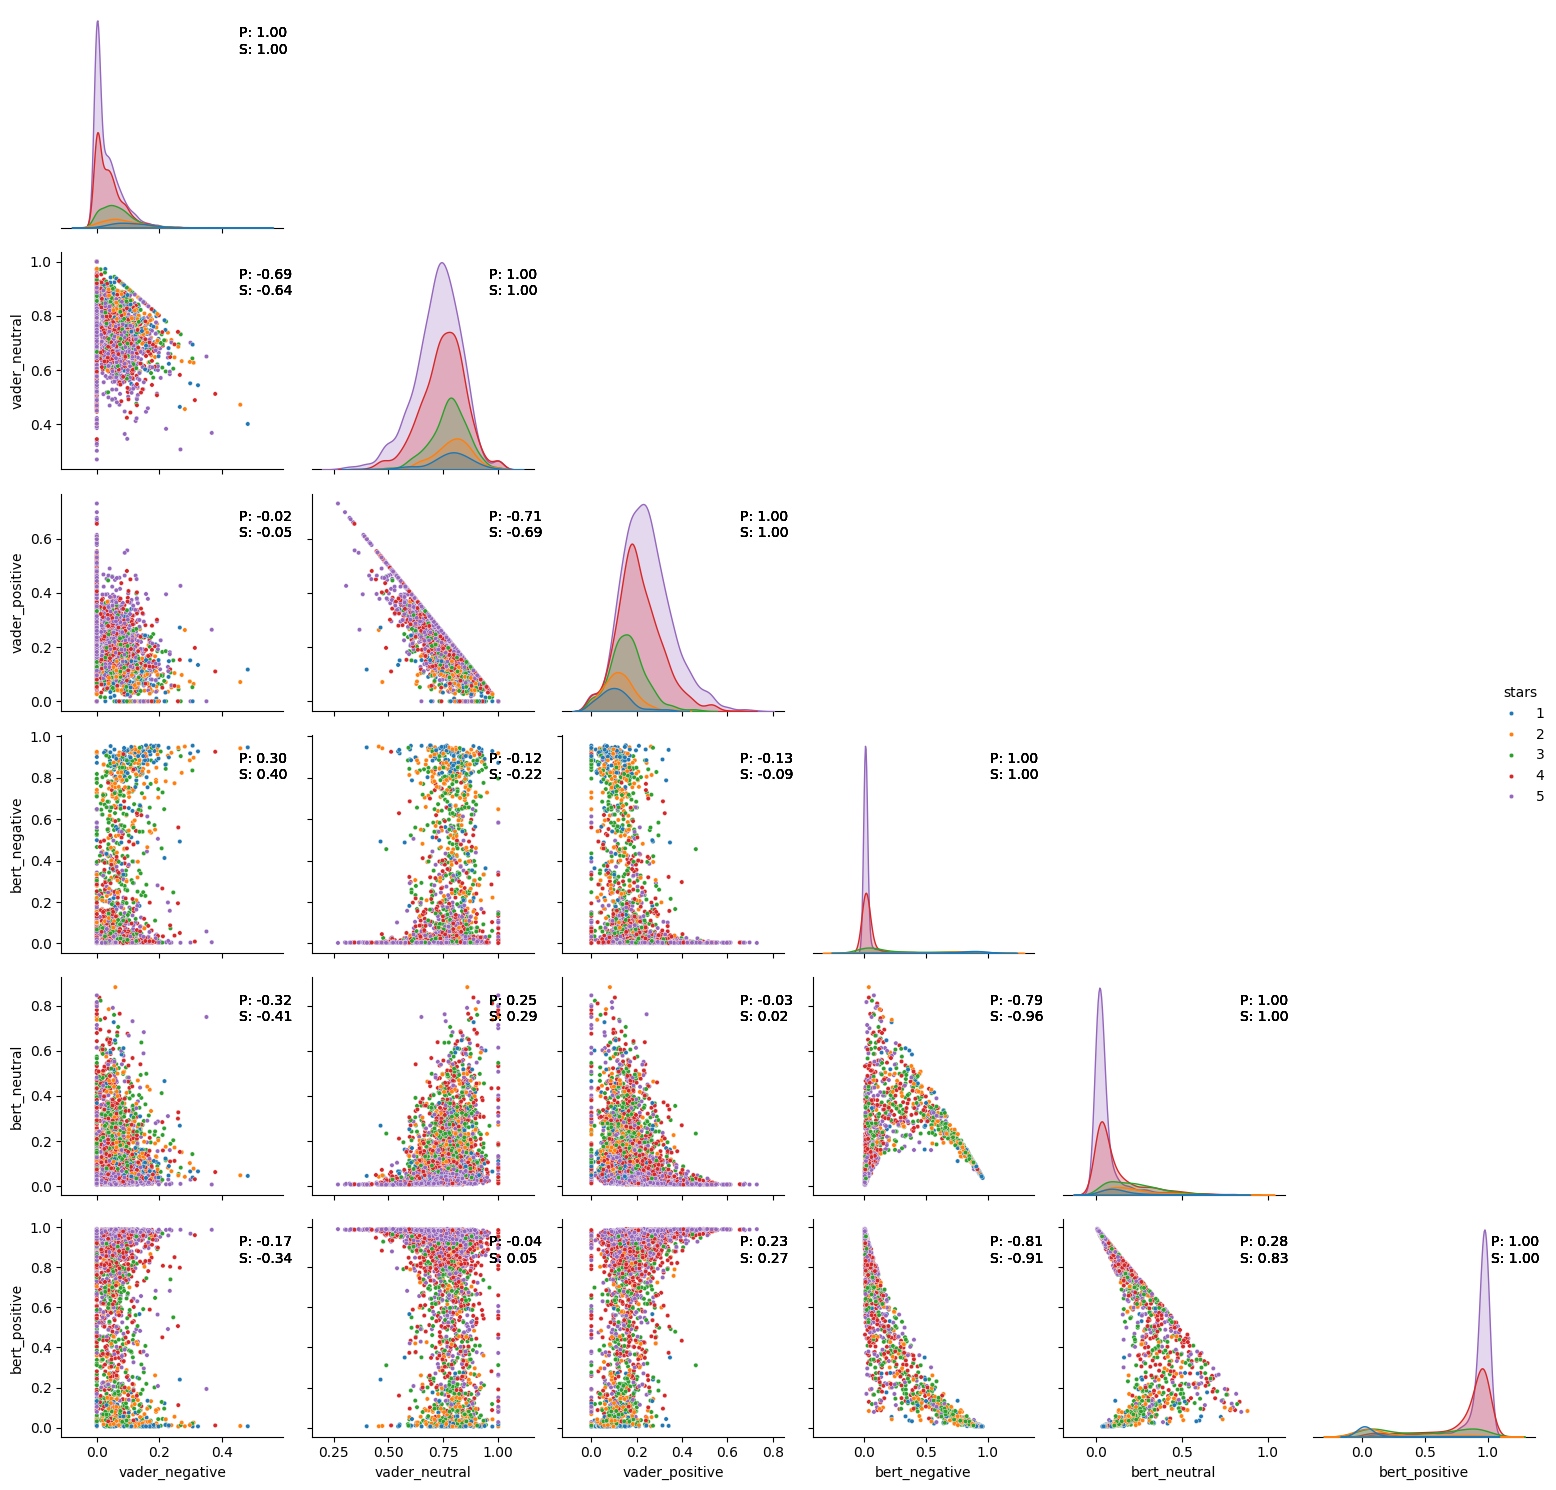

In [21]:
from scipy.stats import pearsonr, spearmanr

# Using a cache to check that we haven't already calculated the corr coefs for each pair of score sets
# If we calculate without checking this cache, we calculate each corr coef 5x more times than needed
correlation_cache = {}

def annotate_corr(x, y, ax=None, **kwargs):
    # get col pair names
    col_pair = (x.name, y.name)

    # calculate corr coefs for unseen col combos
    if col_pair not in correlation_cache:
        pearson_corr, _ = pearsonr(x, y)
        spearman_corr, _ = spearmanr(x, y)
        correlation_cache[col_pair] = (pearson_corr, spearman_corr)
    else:
        pearson_corr, spearman_corr = correlation_cache[col_pair]

    # add text to pairgrid
    ax = ax or plt.gca()
    ax.annotate(f"P: {pearson_corr:.2f}\nS: {spearman_corr:.2f}",
                xy=(0.8, 0.8),
                xycoords=ax.transAxes,
                fontsize=10)

# create plot
g = sns.pairplot(data=df,
                 vars=['vader_negative', 'vader_neutral', 'vader_positive',
                       'bert_negative', 'bert_neutral', 'bert_positive'],
                 hue='stars',
                 palette='tab10',
                 corner=True,
                 plot_kws={"s": 10})

# add corr coefs
g.map(annotate_corr)

# show plot
plt.tight_layout()
plt.show()

These correlation values indicate some interesting insights:
- When comparing matched-sentiment scores from each model (like `vader_negative`:`bert_negative`), we see a generally positive correlation, indicating Vader and Bert tend to agree with eachother (though not perfectly.)
- `bert_negative`:`bert_neutral` shows a stronger correlation than `bert_negative`:`bert_positive`, which seems counterintuitive. We would expect negative:positive scores to have the strongest inverse correlation. However, I think this is an effect of how Bert assigns scores: Bert scores are probabilities that sum to 1 due to softmax normalization. Therefore, a high `bert_negative` score would reduce the available 'space' for `bert_neutral` and `bert_positive` scores. Bert seems to use neutral as a buffer category, assigning higher neutral scores when the sentiment is ambiguous. For strongly negative reviews, the 'uncertainty' captured by the neutral score diminishes sharply, causing a stronger inverse correlation between `bert_negative` and `bert_neutral`.
- `bert_positive`:`bert_negative` shows a strong negative correlation of -0.82, which aligns with our expectations and indicates that Bert operates on a trade-off scale: if something is more positive, it is inherently less negative. We might say that Bert scores with a measure of mutual exclusivity--Bert will not score something as being both very positive and very negative.
- However, the same comparison in Vader (`vader_positive`:`vader_negative`) shows barely any correlation at all: 0.04! This indicates that Vader doesn't perceive positive and negative sentiment as mutually exclusive. This checks out with our knowledge of how Vader operates (on a lexicon basis). Vader might rank a sentence like “I love this, but the service was terrible” as both very positive and very negative, because 'love' is very positive and 'terrible' is very negative.

Let's look at the reviews where Vader and Bert differ the most:

In [22]:
vader_cols = ['vader_negative', 'vader_neutral', 'vader_positive']
bert_cols = ['bert_negative', 'bert_neutral', 'bert_positive']

# calc the total absolute difference for each row and sort
df['total_diff'] = df.apply(
    lambda row: sum(abs(row[vader] - row[bert]) for vader, bert in zip(vader_cols, bert_cols)), axis=1
)
df = df.sort_values(by='total_diff', ascending=False)
df.head()

,review_id,stars,text,date,vader_negative,vader_neutral,vader_positive,compound,bert_negative,bert_neutral,bert_positive,total_diff
3483,_KItVY3qW7Cxx9aCJgwdlw,4,Tried oysters for the first time at Acme!!! So...,2013-09-29 21:09:59,0.000,1.000,0.0,0.0000,0.0018,0.0128,0.9853,1.9743
31,6JN7r8pfAqZo6wtoj7tgeA,4,Went here for crawfish but it is not crawfish ...,2018-06-29 05:07:04,0.000,1.000,0.0,0.0000,0.0033,0.0167,0.9800,1.9666
515,VSDAnOwT_aB0dAl3R_s9kA,4,One of our go to places whenever we are in NOL...,2018-05-25 22:57:41,0.198,0.802,0.0,-0.6360,0.0029,0.0189,0.9782,1.9564
2727,g2ZNkHasAoVzOx3FQDTbsQ,5,"Went here for my birthday in January, we only ...",2019-04-28 15:22:58,0.140,0.860,0.0,-0.6416,0.0058,0.0196,0.9746,1.9492
1600,46fj6X8AjosBnP0yszpFXA,4,We tried the fried catfish and oyster platter....,2010-11-05 15:56:58,0.000,1.000,0.0,0.0000,0.0022,0.0264,0.9714,1.9472


It appears that the biggest differences between models come when Vader doesn't detect a strong sentiment. Bert scores these reviews more accurately, rather than just classifying them as neutral. Again, this appears to be because Bert doesn't work on a lexicon basis, but rather interprets the entire text together.

Let's look at some reviews where model scoring and the actual star rating differ:

In [23]:
# 1 star, Bert thinks it's positive
one_star_bert_pos = df.query('stars == 1').sort_values('bert_positive', ascending=False)['text'].values[0]

# 1 star, Vader thinks it's positive
one_star_vader_pos = df.query('stars == 1').sort_values('vader_positive', ascending=False)['text'].values[0]

# 5 stars, Bert thinks it's negative
five_stars_bert_neg = df.query('stars == 5').sort_values('bert_negative', ascending=False)['text'].values[0]

# 5 stars, Vader thinks it's negative
five_stars_vader_neg = df.query('stars == 5').sort_values('vader_negative', ascending=False)['text'].values[0]

print(one_star_bert_pos)
print(one_star_vader_pos)
print(five_stars_bert_neg)
print(five_stars_vader_neg)

My husband had been there numerous times over the years  and was excited to return; I had never been there and was excited to eat there after hearing so many good things.  We walked in the door, uncertain if we were supposed to be seated or seat and even though there was no one in front of us, the hostess literally yelled at us to go wait outside.  We did and not less than one minute later, she knocked on the window and yelled for us to follow her. She sat us in the back at a community table, without menus. She came back and gave us menus, told us who our server would be and walked off. We looked over the menus, and then sat and waited for about 15 minutes. The server never greeted us, never even took a drink order, never offered water, nothing. The restaurant was cramped,  noisy and dirty; I'm sure the noise and cramped quarters give it some charm, as we enjoy "dive" restaurants in our hometown, Denver, but dirty is never pleasant to experience in a restaurant. 

We understand being b

These discrepencies highlight the key drawback of sentiment analysis: it's not detailed enough. A review can contain positive sentiment for one thing (like taste), but negative sentiment for another (like service). We call these ideas 'aspects'. Using aspect based sentiment analysis, we can evaluate the sentiment of specific aspects and look at which aspects tend to be reviewed negatively or positively. With this data, we might find that a certain aspect tends to be reviewed more positively or negatively, and the business could improve or highlight that aspect.

In this way, we get to an actionable granularity of sentiment. Instead of just calculating the general sentiment towards the business, we can identify specific problem areas or successes for the business, enabling them to improve and grow.

For this use case, we'll grab another version of Bert (technically, deBerta) that is tuned to output sentiment scores for a specific aspect of a text input.

## Aspect-based Analysis: Thematic Similarity

In [24]:
absa_model_name = "yangheng/deberta-v3-base-absa-v1.1"
absa_tokenizer = AutoTokenizer.from_pretrained(absa_model_name)
absa_model = AutoModelForSequenceClassification.from_pretrained(absa_model_name)
absa_config = AutoConfig.from_pretrained(absa_model_name)

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Let's do a test input, and get the scores for service, food, host, waiter, and experience aspects. With this test pipeline, we're only returning the strongest sentiment score for each aspect. When we apply this to our dataset, we'll store the negative, neutral, and positive scores for each aspect.

In [25]:
from transformers import pipeline

absa_pipeline = pipeline("text-classification", model=absa_model, tokenizer=absa_tokenizer) # using a pipeline to streamline test examples
aspects = ['service', 'food', 'host', 'waiter', 'experience']
test_text = "The food tasted great and the host was super nice, but my waiter was rude. Totally ruined the experience."

for aspect in aspects:
    print(aspect, absa_pipeline(test_text, text_pair=aspect))

Device set to use cuda:0


service [{'label': 'Negative', 'score': 0.9665026664733887}]
food [{'label': 'Positive', 'score': 0.9954904913902283}]
host [{'label': 'Positive', 'score': 0.9963456988334656}]
waiter [{'label': 'Negative', 'score': 0.9934017062187195}]
experience [{'label': 'Negative', 'score': 0.9717264175415039}]


We can see that deBerta correctly interprets the positive sentiment towards the food and the host, and correctly interprets the negative sentiment towards the waiter, service, and experience.

Let's run ABSA on all 3500 reviews we have!

A note on speed: we're doing a lot more calculations than with the previous model, so expect this cell to take awhile to run. On an M2 Pro Macbook, it took 4 hours on the CPU backend and 3.5 hours on the MPS backend. I ended up moving this notebook to Google Colab on Cuda backend, and it only took about 5 mins to run this cell. If you want to run this whole analysis yourself, I'd suggest doing it in Colab on a GPU (T4 or better) backend. If you want to run on something else, change `device` in cell 17 to the relevant string value.

In [26]:
absa_model.to(device)

# convert columns to lists for faster iteration
absa_texts = df['text'].tolist()
absa_review_ids = df['review_id'].tolist()
aspects = ['service', 'food', 'staff', 'experience']

absa_tokenized_texts = []
absa_aspects = []
absa_review_ids_repeated = []

for review_id, absa_text in tqdm(zip(absa_review_ids, absa_texts),
                                 total=len(absa_texts),
                                 desc="Tokenizing"):
    for aspect in aspects:
        absa_tokens = absa_tokenizer(f"[CLS] {absa_text} [SEP] {aspect} [SEP]",
                                     return_tensors="pt",
                                     truncation=True,
                                     padding=True,
                                     max_length=512).to(device)
        absa_tokenized_texts.append(absa_tokens)
        absa_aspects.append(aspect)
        absa_review_ids_repeated.append(review_id)

absa_results = {}
model.eval()

for absa_token_text, absa_aspect, absa_review_idx in tqdm(zip(absa_tokenized_texts, absa_aspects, absa_review_ids_repeated), total=len(absa_tokenized_texts), desc="Predicting"):
    try:
        with torch.inference_mode():
            absa_output = absa_model(**absa_token_text) # send input through bert
            absa_scores = absa_output[0][0].cpu().detach().numpy() # send to cpu, extract logits, convert to ndarray
            absa_scores = softmax(absa_scores) # normalize scores

        current_review_absa_scores = {label: round(float(absa_scores[i]), 4)
                                      for i, label in enumerate(absa_config.id2label.values())}

        if absa_review_idx not in absa_results:
            absa_results[absa_review_idx] = {}
        absa_results[absa_review_idx][absa_aspect] = current_review_absa_scores # add {absa_review_idx[absa_aspect]:scores} to overall dict'
    except Exception as e:
         print(f"Broke for review_id: {absa_review_idx}")
         print(f"Error trace: {e}")

Predicting: 100%|██████████| 14000/14000 [05:17<00:00, 44.05it/s]


Let's merge these scores with our main df, and then visualize them:

In [27]:
review_rows = []
for review_id, categories in absa_results.items():
    row = {'review_id': review_id}
    for category, sentiments in categories.items():
        for sentiment, score in sentiments.items():
            column_name = f"absa_{category}_{sentiment[:3].lower()}"
            row[column_name] = score
    review_rows.append(row)

absa_scores_df = pd.DataFrame(review_rows)
df = df.merge(absa_scores_df, on='review_id', how='left')
df.head()

,review_id,stars,text,date,vader_negative,vader_neutral,vader_positive,compound,bert_negative,bert_neutral,...,absa_service_pos,absa_food_neg,absa_food_neu,absa_food_pos,absa_staff_neg,absa_staff_neu,absa_staff_pos,absa_experience_neg,absa_experience_neu,absa_experience_pos
0,_KItVY3qW7Cxx9aCJgwdlw,4,Tried oysters for the first time at Acme!!! So...,2013-09-29 21:09:59,0.000,1.000,0.0,0.0000,0.0018,0.0128,...,0.9240,0.0091,0.7915,0.1993,0.0268,0.1490,0.8242,0.0058,0.1089,0.8853
1,6JN7r8pfAqZo6wtoj7tgeA,4,Went here for crawfish but it is not crawfish ...,2018-06-29 05:07:04,0.000,1.000,0.0,0.0000,0.0033,0.0167,...,0.9560,0.0114,0.0668,0.9218,0.0059,0.0244,0.9697,0.0072,0.0296,0.9632
2,VSDAnOwT_aB0dAl3R_s9kA,4,One of our go to places whenever we are in NOL...,2018-05-25 22:57:41,0.198,0.802,0.0,-0.6360,0.0029,0.0189,...,0.5008,0.0208,0.7539,0.2253,0.0424,0.6573,0.3003,0.0168,0.6917,0.2916
3,g2ZNkHasAoVzOx3FQDTbsQ,5,"Went here for my birthday in January, we only ...",2019-04-28 15:22:58,0.140,0.860,0.0,-0.6416,0.0058,0.0196,...,0.9654,0.0140,0.2234,0.7626,0.0064,0.0420,0.9516,0.0041,0.0364,0.9595
4,46fj6X8AjosBnP0yszpFXA,4,We tried the fried catfish and oyster platter....,2010-11-05 15:56:58,0.000,1.000,0.0,0.0000,0.0022,0.0264,...,0.9555,0.0060,0.1169,0.8772,0.0096,0.1092,0.8812,0.0032,0.0498,0.9469


Looking at raw values in a dataframe is pretty unhelpful. Let's try visualzing the distribution of each aspect's sentiment:

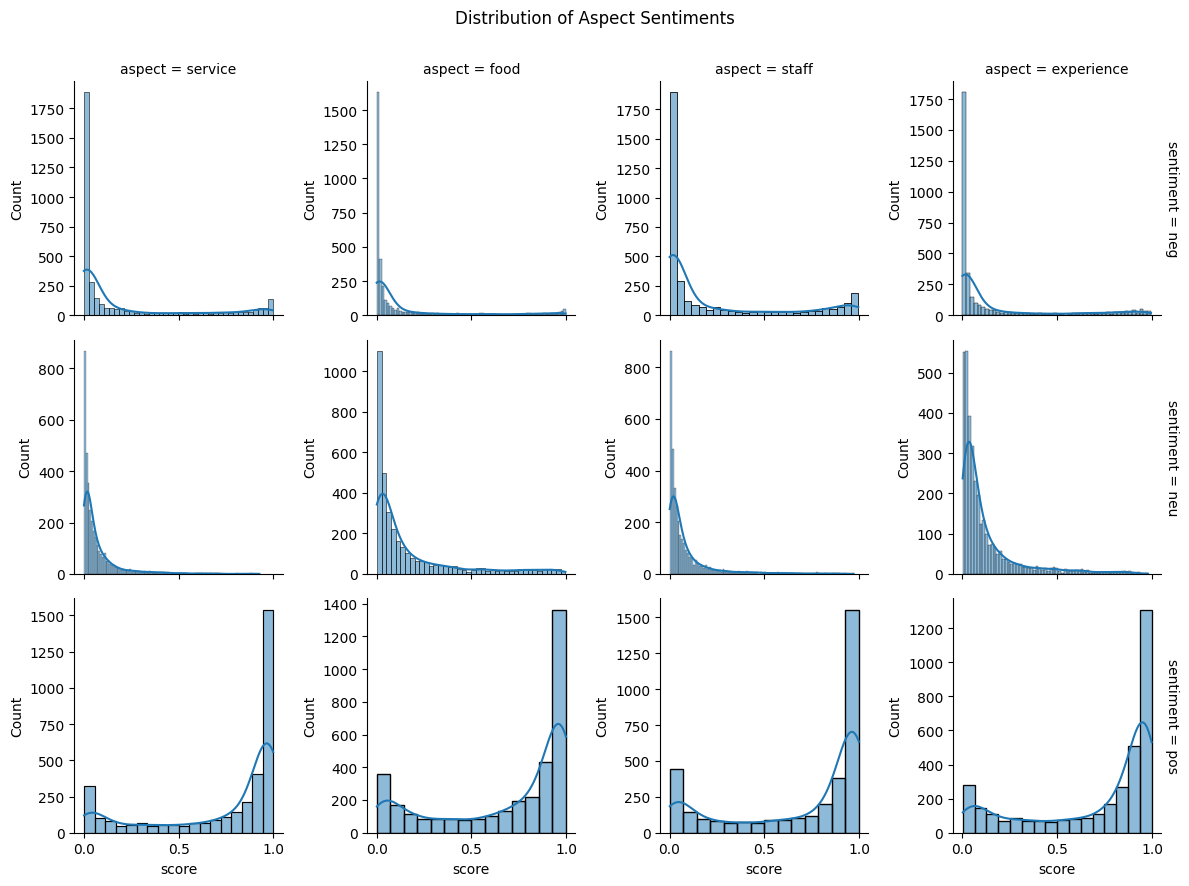

In [28]:
melted_absa_df = absa_scores_df.melt(id_vars=['review_id'],
                                value_vars=[col for col in absa_scores_df.columns if 'absa' in col],
                                var_name='aspect_sentiment',
                                value_name='score')

# Split the 'aspect_sentiment' column into two: 'aspect' and 'sentiment'
melted_absa_df[['aspect', 'sentiment']] = melted_absa_df['aspect_sentiment'].str.extract(r'absa_(\w+)_(\w+)')

# Create the FacetGrid
g = sns.FacetGrid(
    melted_absa_df,
    row="sentiment",  # Separate rows for negative, neutral, positive
    col="aspect",     # Separate columns for service, food, staff, experience
    margin_titles=True,
    sharex=True,
    sharey=False
)

# Map a distribution plot to the grid
g.map(sns.histplot, "score", kde=True)

# Adjust layout and show the plot
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Distribution of Aspect Sentiments")
plt.show()

We can see that across the board, ABSA doesn't detect neutral or ambiguous sentiment for any of the aspects.

However, there's a notable uptick in high negative scores for 'staff', and a smaller uptick in negative scores for 'service'. Let's check how many reviews have strong negative or positive sentiment for each aspect:

In [29]:
# Define thresholds for high negative and high positive sentiment
negative_threshold = 0.95
positive_threshold = 0.95

# Select relevant ABSA columns for analysis
absa_columns = [col for col in absa_scores_df.columns if 'absa' in col]

# Calculate the frequency of high negative and high positive sentiments
negative_counts = absa_scores_df[[col for col in absa_columns if 'neg' in col]].gt(negative_threshold).sum()
positive_counts = absa_scores_df[[col for col in absa_columns if 'pos' in col]].gt(positive_threshold).sum()

# Create a summary DataFrame for insights
insights_df = pd.DataFrame({
    'Aspect': [col.split('_')[1] for col in negative_counts.index],
    'High Negative Count': negative_counts.values,
    'High Positive Count': positive_counts.values
})

# Sort by high negative and positive counts for prioritization
insights_df = insights_df.sort_values(by=['High Negative Count', 'High Positive Count'], ascending=[False, False])
insights_df.head()


,Aspect,High Negative Count,High Positive Count
2,staff,210,1313
0,service,193,1458
1,food,111,1154
3,experience,83,1104


Looks like we were right! There is a larger chunk of negative sentiment about staff and service--almost double the count of negative sentiments about the food or the experience. Let's plot the sentiment scores on a histogram to A:B compare:

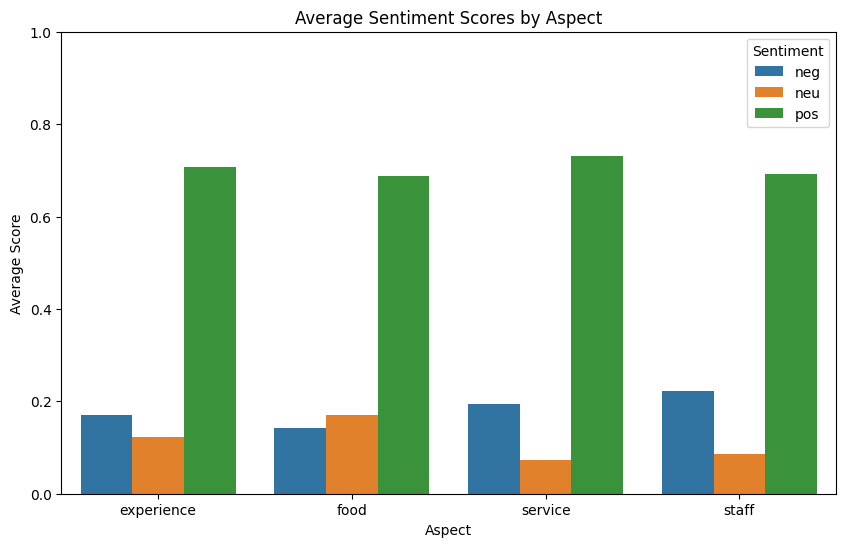

In [30]:
# Aggregate the sentiment scores by aspect and sentiment
aggregated_scores = melted_absa_df.groupby(['aspect', 'sentiment'])['score'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=aggregated_scores, x='aspect', y='score', hue='sentiment')
plt.title("Average Sentiment Scores by Aspect")
plt.ylabel("Average Score")
plt.xlabel("Aspect")
plt.ylim(0, 1)
plt.legend(title="Sentiment")
plt.show()

Indeed, service and staff seem to be a problem source. All 4 aspects have roughly the same average positive score, but service and staff have much higher average negative scores and lower average neutral scores.

And there we have our answer! It seems like the business's main issue is with staffing and service quality. This analysis enables the business to tackle the issue(s) that cause the most negative reviews. They could proceed by looking at the reviews with strong negative staff or service sentiment, and noting any specific issues mentioned: individuals, speed of service, etc.